# Hente tabeller med datokonvertering
## Eksempel Konkurs
Denne ukentlige tabellen for har et brudd i  tidsserien fra 2010-2018. Den er egnet for å vise funksjonen for datokonvertering. Her vises figurer både med x-akse som kategorier og som dato.

Kilde: [12972](https://www.ssb.no/statbank/table/12972) - Opna  konkursar ukentleg

In [1]:
# Her importerer vi ulike pakker
import requests
import pandas as pd
from pyjstat import pyjstat  # pyjstat er for behandling av JSON-stat


URL til tabellens metadata i PxWebApi, som vi skal poste spørringene mot

In [2]:
tabid = "12972" 
lang = "no" # kan også være "en"
url1 = "https://data.ssb.no/api/v0/" + lang + "/table/" + tabid;

Vi spør etter Antall konkurser og antall ansatte pr uke, for alle næringer. 

In [3]:
query1 = {
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "item",
        "values": [
          "0N"
        ]
      }
    },
    {
      "code": "Naring",
      "selection": {
        "filter": "item",
        "values": [
          "00-99"
        ]
      }
    },

    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "Konkursar"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "all",
        "values": [
          "*"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


### Generell funksjon for å identifisere frekvens slik at vi kan konvertere til datoformat og sette [**Pandas PeriodIndex**](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-span-representation)

In [4]:
#identifiserer frekvens, konverterer til datoformat og setter Periodindex
def dateConv(dataframe):
    frekvens, frek_no, frek_en, fmt = findFrequency(dataframe)
    setPeriodIndex(frekvens, frek_no, frek_en, fmt, dataframe)

#funksjon for frekvenser    
def findFrequency(dataframe):
    frekvenser = ['måned', 'kvartal', 'uke', 'år', 'year', 'quarter', 'month', 'week']
    frek_no = ''  #SSB bruker dessverre norske og ikke engelske frekvenskoder U - uke osv.
    frek_en = '' #engelsk frekvens kode
    fmt = '' # python datoformat
    for w in frekvenser:
        if w in dataframe.columns:
            if w in ['måned', 'month']:
                frek_no = 'M'
                frek_en = 'M'
                fmt = '%YM%m'
            elif w in ['kvartal', 'quarter']:
                frek_no = 'K'
                frek_en = 'Q'
            elif w in ['uke', 'week']:
                frek_no = 'U';
                frek_en = 'W'
                fmt = '%YW%W-%w'
            else:
                frek_no = ''
                frek_en = 'A'
            return w, frek_no, frek_en, fmt
    
# funksjon for å konvertere til datoformat og sette en Pandas PeriodIndex.        
def setPeriodIndex(frekvens, frek_no, freq_en, fmt, df):
    if frekvens in ['kvartal', 'quarter']:
        # erstatter K med Q, konverterer til datoformat og setter frekensen til Pandas PeriodIndex. 
        # Pandas forstår engelske frekevenskoder, men SSB bruker norske
        df.index = pd.PeriodIndex(pd.to_datetime(df[frekvens].str.replace(frek_no, freq_en), errors='coerce'), freq='Q-DEC')
    elif frekvens in ['uke', 'week']:
        # må legge til '-0' for å få ukenr. til å bli mnd-dag
        df.index = pd.PeriodIndex(pd.to_datetime(df[frekvens].str.replace(frek_no, freq_en).add('-0'), format= fmt, errors='coerce'), freq='W-MON')
    else:
        df.index =  pd.PeriodIndex(pd.to_datetime(df[frekvens], format= fmt, errors='coerce'), freq=freq_en)


### Her poster vi spørringen

In [5]:
res1 = requests.post(url1, json=query1)

### Leser JSON-stat resultatet med biblioteket pyjstat

In [6]:
ds1 = pyjstat.Dataset.read(res1.text)

### Skriver resultatet til en Pandas dataframe

In [7]:
df1 = ds1.write('dataframe')

Viser tre først og tre siste i df1

In [8]:
df1.head(3)

,region,næring,statistikkvariabel,uke,value
0,Heile landet,Alle næringar,Konkursar,2009U01,92
1,Heile landet,Alle næringar,Konkursar,2009U02,86
2,Heile landet,Alle næringar,Konkursar,2009U03,110


In [9]:
df1.tail(3)

,region,næring,statistikkvariabel,uke,value
120,Heile landet,Alle næringar,Konkursar,2020U24,64
121,Heile landet,Alle næringar,Konkursar,2020U25,82
122,Heile landet,Alle næringar,Konkursar,2020U26,71


In [10]:
df1.set_index('uke')

,region,næring,statistikkvariabel,value
uke,,,,
2009U01,Heile landet,Alle næringar,Konkursar,92
2009U02,Heile landet,Alle næringar,Konkursar,86
2009U03,Heile landet,Alle næringar,Konkursar,110
2009U04,Heile landet,Alle næringar,Konkursar,11
2009U05,Heile landet,Alle næringar,Konkursar,15
...,...,...,...,...
2020U22,Heile landet,Alle næringar,Konkursar,106
2020U23,Heile landet,Alle næringar,Konkursar,77
2020U24,Heile landet,Alle næringar,Konkursar,64


In [11]:
df1.index

RangeIndex(start=0, stop=123, step=1)

Figur med Pandas plot

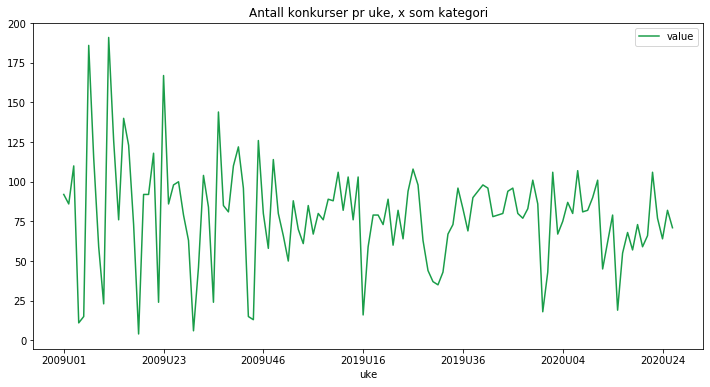

In [12]:
df1.plot(x='uke', y='value', figsize=(12, 6), color='#1a9d49', title="Antall konkurser pr uke, x som kategori")

### Kaller funksjonen dateConv som konverterer til dato. 

Gjør en konvertering fra kategori til datoformat. Deretter settes denne som index med bruk av Pandas PeriodIndex. *Ser at uke konverteringen gir feil dato. Python 3.8 introduserer isocalendar(), som sannsynligvis gir beste løsning. Forslag mottas med takk.*

In [13]:
dateConv(df1)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


Nå har vi fått en Pandas PeriodIndex

In [14]:
df1.index

PeriodIndex(['2009-01-06/2009-01-12', '2009-01-13/2009-01-19',
             '2009-01-20/2009-01-26', '2009-01-27/2009-02-02',
             '2009-02-03/2009-02-09', '2009-02-10/2009-02-16',
             '2009-02-17/2009-02-23', '2009-02-24/2009-03-02',
             '2009-03-03/2009-03-09', '2009-03-10/2009-03-16',
             ...
             '2020-04-28/2020-05-04', '2020-05-05/2020-05-11',
             '2020-05-12/2020-05-18', '2020-05-19/2020-05-25',
             '2020-05-26/2020-06-01', '2020-06-02/2020-06-08',
             '2020-06-09/2020-06-15', '2020-06-16/2020-06-22',
             '2020-06-23/2020-06-29', '2020-06-30/2020-07-06'],
            dtype='period[W-MON]', name='uke', length=123, freq='W-MON')

In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 123 entries, 2009-01-06/2009-01-12 to 2020-06-30/2020-07-06
Freq: W-MON
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   region              123 non-null    object
 1   næring              123 non-null    object
 2   statistikkvariabel  123 non-null    object
 3   uke                 123 non-null    object
 4   value               123 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 5.8+ KB


### Nytt plot med datokonvertert x-akse

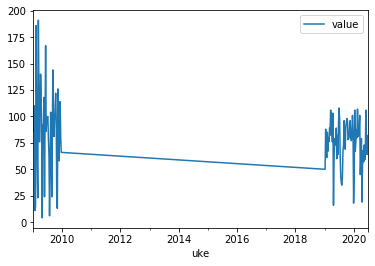

In [16]:
df1.plot() 

### Øker størrelsen på figuren og setter SSB-farger

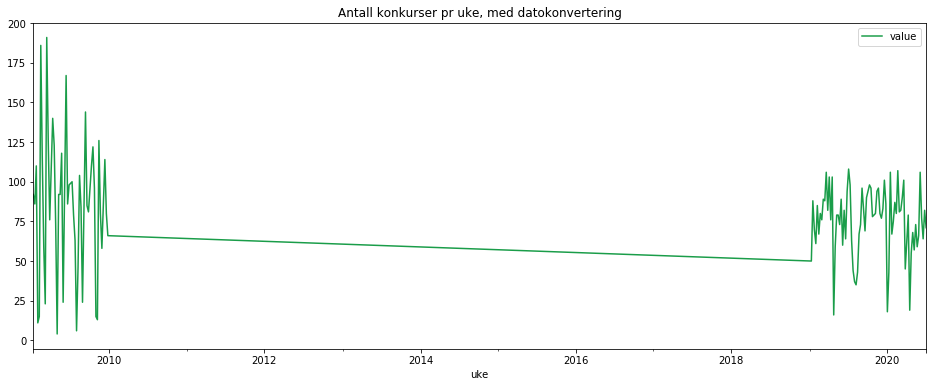

In [17]:
df1.plot(figsize=(16, 6), color='#1a9d49', title="Antall konkurser pr uke, med datokonvertering")